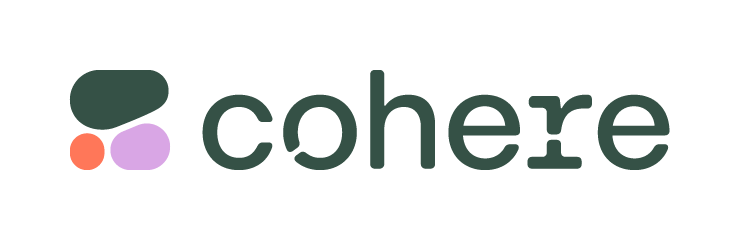

# Notebook Overview

## Motivation
Enterprise customers often store and handle information in relational databases but querying such databases effectively requires bespoke knowledge of the underlying database structure as well as strong SQL coding skills. One way to address these challenges is to build an LLM agent capable of generating and executing SQL queries based on natural language. For example If a user asks: ``what are the top 4 rows in table X``, the agent should be able to generate ``SELECT * FROM X LIMIT 4``, execute this query and return the output to the user. 

## Objective
In this notebook we explore how to setup a sql agent using langchain and Cohere models. We explore two ways to achieve this, one using the [create_sql_agent](https://api.python.langchain.com/en/latest/sql_agent/langchain_cohere.sql_agent.agent.create_sql_agent.html) abstraction from langchain-cohere, and another using the [Cohere ReAct Agent](https://github.com/langchain-ai/langchain-cohere/blob/main/libs/cohere/langchain_cohere/cohere_agent.py) to answer questions over SQL Databases. We show how this can be done seamlessly with langchain's existing SQLDBToolkit.

The [create_sql_agent](https://api.python.langchain.com/en/latest/sql_agent/langchain_cohere.sql_agent.agent.create_sql_agent.html) option is recommended for most use cases and can be setup without much hassle.

## Table of Contents

- [SQL Agent with create_sql_agent](#sec_step0)
- [SQL Agent using Cohere ReAct Agent](#sec_step1)
    - [Toolkit Setup](#sec_step2)
    - [SQL Agent](#sec_step3)
    - [SQL Agent with context](#sec_step4)

<a id="sec_step0"></a>
# SQL Agent with create_sql_agent



In [10]:
from langchain_cohere import ChatCohere, create_sql_agent
from langchain_community.utilities.sql_database import SQLDatabase
import os

In [7]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################

#!pip install --quiet langchain langchain_cohere langchain_experimental --upgrade

In [12]:
# load the cohere api key
os.environ["COHERE_API_KEY"] = ""

In [14]:
DB_NAME='Chinook.db'
MODEL="command-r-plus"

llm = ChatCohere(model=MODEL, temperature=0.1,verbose=True)
db = SQLDatabase.from_uri(f"sqlite:///{DB_NAME}")

In [16]:
agent_executor = create_sql_agent(llm, db=db, verbose=True)

The create_sql_agent abstraction comes with access to the SQLDBTookit, and presents itself as an easy-to-use low-code solution to create an agent to answer questions over a db knowledge source. 



In [20]:
agent_executor.invoke({
   "input": 'what tables are available?',
})



> Entering new Cohere SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{'tool_input': ''}`
responded: I will use the sql_db_list_tables tool to find out what tables are available in the database.

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, TrackThe following tables are available:
- Album
- Artist
- Customer
- Employee
- Genre
- Invoice
- InvoiceLine
- MediaType
- Playlist
- PlaylistTrack
- Track

> Finished chain.


{'input': 'what tables are available?',
 'output': 'The following tables are available:\n- Album\n- Artist\n- Customer\n- Employee\n- Genre\n- Invoice\n- InvoiceLine\n- MediaType\n- Playlist\n- PlaylistTrack\n- Track'}

The agent is able to invoke the correct tool from the toolkit in order to find out the tables available in the db.

In [21]:
agent_executor.invoke({
   "input": "who is the best customer? The customer who has spent the most money is the best. Please write and execute the correct sql query to answer this question, and give me the result!",
})



> Entering new Cohere SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`
responded: I will first list the tables in the database, then I will query the schema of the most relevant tables. After that, I will write and execute a SQL query to answer the user's question.

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
Invoking: `sql_db_schema` with `{'table_names': 'Customer, Invoice'}`
responded: The tables in the database are: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track.

The most relevant tables for the user's question are Customer and Invoice. I will now query the schema of these tables.


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"Po

{'input': 'who is the best customer? The customer who has spent the most money is the best. Please write and execute the correct sql query to answer this question, and give me the result!',
 'output': 'The best customer is Helena Holý, who has spent a total of 49.62.'}

The agent is able to execute and query the relevant tables, including performing necessary table joins to answer the user query.

<a id="sec_step1"></a>
# SQL Agent using Cohere ReAct Agent



In the above section, we made use of an built in abstraction from langchain to perform question answering over a db knowledge source. 
Let us now build a similar agent from the ground up and understand better how the different components like tools, prompts and function calling work hand in hand to enable a succesful agent implementation.

<a id="sec_step2"></a>
## Toolkit Setup



In [1]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere.chat_models import ChatCohere
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
import os

In [2]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################

#!pip install --quiet langchain langchain_cohere langchain_experimental --upgrade

Langchain already has a SQLDBToolkit that consists of 4 tools to handle SQL query generation, execution and validation. To use this, you simply need to define your LLM and DB and pass these into the Toolkit.

These are the following tools:
- 'sql_db_query': executes SQL code on the database
- 'sql_db_schema': returns the schema of tables given the list of tables
- 'sql_db_list_tables': lists the tables in the database
- 'sql_db_query_checker': validates the SQL query




In [4]:
# load the cohere api key
os.environ["COHERE_API_KEY"] = ""

In [11]:

DB_NAME='Chinook.db'
MODEL="command-r-plus"

llm = ChatCohere(model=MODEL, temperature=0.1,verbose=True)
db = SQLDatabase.from_uri(f"sqlite:///{DB_NAME}")


toolkit = SQLDatabaseToolkit(db=db, llm=llm)
context = toolkit.get_context()
tools = toolkit.get_tools()

print('**List of pre-defined Langchain Tools**')
print([tool.name for tool in tools])
print('')
print('**Context to pass to LLM on tables**')
print(context)

**List of pre-defined Langchain Tools**
['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']

**Context to pass to LLM on tables**
{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(

<a id="sec_step3"></a>
## SQL Agent

we follow the general cohere react agent setup in Langchain to build our SQL agent.

In [13]:

# define the prompt template
prompt = ChatPromptTemplate.from_template("{input}")

# instantiate the ReAct agent
agent = create_cohere_react_agent(
   llm=llm,
   tools=tools,
   prompt=prompt,
)
agent_executor = AgentExecutor(agent=agent,
                               tools=tools,
                               verbose=True,
                               return_intermediate_steps=True
                    )



In [14]:
agent_executor.invoke({
   "input": 'what tables are available?',
})



> Entering new AgentExecutor chain...

I will use the sql_db_list_tables tool to find out what tables are available.
{'tool_name': 'sql_db_list_tables', 'parameters': {'tool_input': ''}}
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, TrackRelevant Documents: 0
Cited Documents: 0
Answer: The following tables are available: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track.
Grounded answer: The following tables are available: <co: 0>Album</co: 0>, <co: 0>Artist</co: 0>, <co: 0>Customer</co: 0>, <co: 0>Employee</co: 0>, <co: 0>Genre</co: 0>, <co: 0>Invoice</co: 0>, <co: 0>InvoiceLine</co: 0>, <co: 0>MediaType</co: 0>, <co: 0>Playlist</co: 0>, <co: 0>PlaylistTrack</co: 0>, <co: 0>Track</co: 0>.

> Finished chain.


{'input': 'what tables are available?',
 'output': 'The following tables are available: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track.',
 'citations': [CohereCitation(start=36, end=41, text='Album', documents=[{'output': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track'}]),
  CohereCitation(start=43, end=49, text='Artist', documents=[{'output': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track'}]),
  CohereCitation(start=51, end=59, text='Customer', documents=[{'output': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track'}]),
  CohereCitation(start=61, end=69, text='Employee', documents=[{'output': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track'}]),
  CohereCitation(start=71, end=76, text='Genre', do

The agent uses the list_tables tool to effectively highlight all the tables in the DB

In [16]:
agent_executor.invoke({
   "input": 'show the first row of the Playlist and Genre tables?',
})



> Entering new AgentExecutor chain...

I will use the sql_db_schema tool to find the first row of the Playlist and Genre tables.
{'tool_name': 'sql_db_schema', 'parameters': {'table_names': 'Playlist, Genre'}}

CREATE TABLE "Genre" (
	"GenreId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("GenreId")
)

/*
3 rows from Genre table:
GenreId	Name
1	Rock
2	Jazz
3	Metal
*/


CREATE TABLE "Playlist" (
	"PlaylistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("PlaylistId")
)

/*
3 rows from Playlist table:
PlaylistId	Name
1	Music
2	Movies
3	TV Shows
*/Relevant Documents: 0
Cited Documents: 0
Answer: Here is the first row of the Genre table:

| GenreId | Name |
| --- | --- |
| 1 | Rock |

Here is the first row of the Playlist table:

| PlaylistId | Name |
| --- | --- |
| 1 | Music |
Grounded answer: Here is the first row of the Genre table:

| <co: 0>GenreId</co: 0> | <co: 0>Name</co: 0> |
| --- | --- |
| <co: 0>1</co: 0> | <co: 0>Rock</co: 0> |

Here is the first row

{'input': 'show the first row of the Playlist and Genre tables?',
 'output': 'Here is the first row of the Genre table:\n\n| GenreId | Name |\n| --- | --- |\n| 1 | Rock |\n\nHere is the first row of the Playlist table:\n\n| PlaylistId | Name |\n| --- | --- |\n| 1 | Music |',
 'citations': [CohereCitation(start=45, end=52, text='GenreId', documents=[{'output': '\nCREATE TABLE "Genre" (\n\t"GenreId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("GenreId")\n)\n\n/*\n3 rows from Genre table:\nGenreId\tName\n1\tRock\n2\tJazz\n3\tMetal\n*/\n\n\nCREATE TABLE "Playlist" (\n\t"PlaylistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("PlaylistId")\n)\n\n/*\n3 rows from Playlist table:\nPlaylistId\tName\n1\tMusic\n2\tMovies\n3\tTV Shows\n*/'}]),
  CohereCitation(start=55, end=59, text='Name', documents=[{'output': '\nCREATE TABLE "Genre" (\n\t"GenreId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("GenreId")\n)\n\n/*\n3 rows from Genre table:\nGenreId

Here we see that the tool takes a list of tables to query the sql_db_schema tool to retrieve the various schemas

In [17]:
agent_executor.invoke({
   "input": 'which countries have the most invoices?',
})



> Entering new AgentExecutor chain...

I will search for the number of invoices per country and then write an answer based on the results.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT country, COUNT(*) AS invoice_count FROM invoices GROUP BY country ORDER BY invoice_count DESC'}}
Error: (sqlite3.OperationalError) no such table: invoices
[SQL: SELECT country, COUNT(*) AS invoice_count FROM invoices GROUP BY country ORDER BY invoice_count DESC]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
I received an error message. I will now use the sql_db_list_tables tool to find out the name of the table containing the invoices data.
{'tool_name': 'sql_db_list_tables', 'parameters': {'tool_input': ''}}
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
I found out that the table name is 'Invoice'. I will now rewrite my query and run it again.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT country

{'input': 'which countries have the most invoices?',
 'output': 'The countries with the most invoices are the USA (91), Canada (56), and France (35).',
 'citations': [CohereCitation(start=45, end=52, text='USA (91', documents=[{'output': "[('USA', 91), ('Canada', 56), ('France', 35), ('Brazil', 35), ('Germany', 28), ('United Kingdom', 21), ('Portugal', 14), ('Czech Republic', 14), ('India', 13), ('Sweden', 7), ('Spain', 7), ('Poland', 7), ('Norway', 7), ('Netherlands', 7), ('Italy', 7), ('Ireland', 7), ('Hungary', 7), ('Finland', 7), ('Denmark', 7), ('Chile', 7), ('Belgium', 7), ('Austria', 7), ('Australia', 7), ('Argentina', 7)]"}]),
  CohereCitation(start=55, end=65, text='Canada (56', documents=[{'output': "[('USA', 91), ('Canada', 56), ('France', 35), ('Brazil', 35), ('Germany', 28), ('United Kingdom', 21), ('Portugal', 14), ('Czech Republic', 14), ('India', 13), ('Sweden', 7), ('Spain', 7), ('Poland', 7), ('Norway', 7), ('Netherlands', 7), ('Italy', 7), ('Ireland', 7), ('Hungary',

The agent initially makes some errors as it jumps to answer the question using the db_query tool, but it then realizes it needs to figure out what tables it has access to and what they look like. It then fixes the sql code and is able to generate the right answer

In [18]:
agent_executor.invoke({
   "input": 'who is the best customer? The customer who has spent the most money is the best.',
})



> Entering new AgentExecutor chain...

I will search for the customer who has spent the most money and write an answer based on the results.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;'}}
Error: (sqlite3.OperationalError) no such table: orders
[SQL: SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
I received an error message. I will now use the sql_db_list_tables tool to find out which tables are available.
{'tool_name': 'sql_db_list_tables', 'parameters': {'tool_input': ''}}
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
I found that there is a 'Customer' table and an 'Invoice' table. I will now use the sql_db_schema tool to find out more about these tables.

{'input': 'who is the best customer? The customer who has spent the most money is the best.',
 'output': 'The best customer is Helena Holý, who has spent a total of 49.62.',
 'citations': [CohereCitation(start=21, end=32, text='Helena Holý', documents=[{'output': "[('Helena', 'Holý', 49.62)]"}]),
  CohereCitation(start=59, end=64, text='49.62', documents=[{'output': "[('Helena', 'Holý', 49.62)]"}])],
 'intermediate_steps': [(AgentActionMessageLog(tool='sql_db_query', tool_input={'query': 'SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;'}, log="\nI will search for the customer who has spent the most money and write an answer based on the results.\n{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT customer_name, SUM(total_price) AS total_spent FROM orders GROUP BY customer_name ORDER BY total_spent DESC LIMIT 1;'}}\n", message_log=[AIMessage(content='\nPlan: I will search for the customer who has spen

As you can see, the agent makes an error, but is able to rectify itself. It also manages to generate SQL query over two tables in the database

<a id="sec_step4"></a>
## SQL Agent with context

From our experiments, we have found that passing in additional context to the preamble can help reduce the initial failures. This context is provided by the SQLDBToolkit and contains the first 3 rows of the tables in the Database

In [19]:
context

{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Supp

We can pass this context into the preamble and re-run a query to see how it performs.

In [21]:
preamble="""## Task And Context
You use your advanced complex reasoning capabilities to help people by answering their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You may need to use multiple tools in parallel or sequentially to complete your task. You should focus on serving the user's needs as best you can, which will be wide-ranging.

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.

## Additional Information
You are an expert who answers the user's question by creating SQL queries and executing them.
You are equipped with a number of relevant SQL tools.

Here is information about the database:
{schema_info}
""".format(schema_info=context)

In [23]:
agent_executor.invoke({
   "input": 'provide the name of the best customer? The customer who has spent the most money is the best.',
   "preamble": preamble
})



> Entering new AgentExecutor chain...

I will write a SQL query to find the customer who has spent the most money.
{'tool_name': 'sql_db_query', 'parameters': {'query': 'SELECT c.CustomerId, c.FirstName, c.LastName, SUM(i.Total) AS TotalSpent\nFROM Customer c\nJOIN Invoice i ON c.CustomerId = i.CustomerId\nGROUP BY c.CustomerId\nORDER BY TotalSpent DESC\nLIMIT 1;'}}
[(6, 'Helena', 'Holý', 49.62)]Relevant Documents: 0
Cited Documents: 0
Answer: The customer who has spent the most money is Helena Holý.
Grounded answer: The customer who has spent the most money is <co: 0>Helena Holý</co: 0>.

> Finished chain.


{'input': 'provide the name of the best customer? The customer who has spent the most money is the best.',
 'preamble': '## Task And Context\nYou use your advanced complex reasoning capabilities to help people by answering their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You may need to use multiple tools in parallel or sequentially to complete your task. You should focus on serving the user\'s needs as best you can, which will be wide-ranging.\n\n## Style Guide\nUnless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.\n\n## Additional Information\nYou are an expert who answers the user\'s question by creating SQL queries and executing them.\nYou are equipped with a number of relevant SQL tools.\n\nHere is information abou

Great, we can see that passing that additional context actually avoids the error seen in the previous section and gets to the answer in one tool call. Of course this works as long as you have a few tables and a few columns per table. We will follow up with more techniques to improve stability and scalability in another notebook.